In [7]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

%matplotlib inline
pd.set_option('display.max_rows', 200)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from modules.nypd_data import read_orig_file
from modules.nypd_data import filter_raw_data
from modules.nypd_data import save_dated_felonies
from modules.nypd_data import load_dated_felonies
from modules.nypd_data import save_clean_felonies
from modules.nypd_data import load_clean_felonies
from modules.nypd_data import add_offense_category

In [9]:
# Before running: execute "tar -xvf cf.tar.gz" from the root directory of the git repo
# copy clean_felonies.csv into that directory,
# and unzip it 
#
#
# To make the files from scratch (not necessary):
# save_dated_felonies()
# save_clean_felonies()


nypd_data = load_clean_felonies()
add_offense_category(nypd_data)

/Users/jsamet/anaconda2/envs/py3k/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [10]:
nypd_data.pivot_table(
    index=[
        nypd_data['COMPLAINT_DATETIME'].map(lambda x: x.year),
        nypd_data['COMPLAINT_DATETIME'].map(lambda x: x.month),
#        nypd_data['COMPLAINT_DATETIME'].map(lambda x: x.day),
#        nypd_data['COMPLAINT_DATETIME'].map(lambda x: x.hour),
#        'BORO_NM',
        'ADDR_PCT_CD',   # These are not duplicated across boros.
    ],
    values='KY_CD',
    columns='OFFENSE',
    fill_value=0,
    aggfunc=len
)

OFFENSE                                            Homicide  Rape  Robbery  \
COMPLAINT_DATETIME COMPLAINT_DATETIME ADDR_PCT_CD                            
2006               1                  1                   0     1        5   
                                      5                   0     2       16   
                                      6                   0     0       16   
                                      7                   1     1       17   
                                      9                   0     0       17   
                                      10                  0     2        7   
                                      13                  0     2       31   
                                      14                  0     2       29   
                                      17                  1     2        7   
                                      18                  0     0       13   
                                      19                  0     1       24   
                                      20                  0     2       26   
                                      22                  0     0        1   
                                      23                  0     2       26   
                                      24                  0     2       25   
                                      25                  1     2       28   
                                      26                  0     2       11   
                                      28                  3     1       27   
                                      30                  1     4       20   
                                      32                  1     4       34   
                                      33                  1     3       21   
                                      34                  0     2       28   
                                      40                  2     4       29   
                                      41                  0     3       25   
                                      42                  0     3       35   
                                      43                  0     5       37   
                                      44                  0     3       28   
                                      45                  1     1       20   
                                      46                  0     5       51   
                                      47                  2     7       41   
                                      48                  0     5       41   
                                      49                  1     4       24   
                                      50                  1     1       12   
                                      52                  3     3       44   
                                      60                  1     1       32   
                                      61                  1     3       26   
                                      62                  0     1       13   
                                      63                  2     2       25   
                                      66                  0     2       13   
                                      67                  1     8       55   
                                      68                  0     1       15   
                                      69                  1     1       31   
                                      70                  1     5       71   
                                      71                  0     3       25   
                                      72                  1     2       15   
                                      73                  4     7       61   
                                      75                  0     5       74   
                                      76                  0     1        9   
                                      77                  0     2       34   
                      

In [11]:
nypd_data['COMPLAINT_YEAR'] = nypd_data['COMPLAINT_DATETIME'].dt.year
nypd_data['COMPLAINT_MONTH'] = nypd_data['COMPLAINT_DATETIME'].dt.month
nypd_data['COMPLAINT_DAY'] = nypd_data['COMPLAINT_DATETIME'].dt.day
nypd_data['COMPLAINT_HOUR'] = nypd_data['COMPLAINT_DATETIME'].dt.hour
nypd_data['COMPLAINT_DAYOFWEEK'] = nypd_data['COMPLAINT_DATETIME'].dt.dayofweek
nypd_data['COMPLAINT_HOURGROUP'] = nypd_data['COMPLAINT_HOUR'].map(lambda x: 4 * (int(x) // 4))

In [12]:
pivoted_weekday_precinct = nypd_data.pivot_table(
    index=[
        'COMPLAINT_DAYOFWEEK',   
        'COMPLAINT_HOURGROUP'
    ],
    values='KY_CD',
    columns='ADDR_PCT_CD',
    fill_value=0,
    aggfunc=len
)

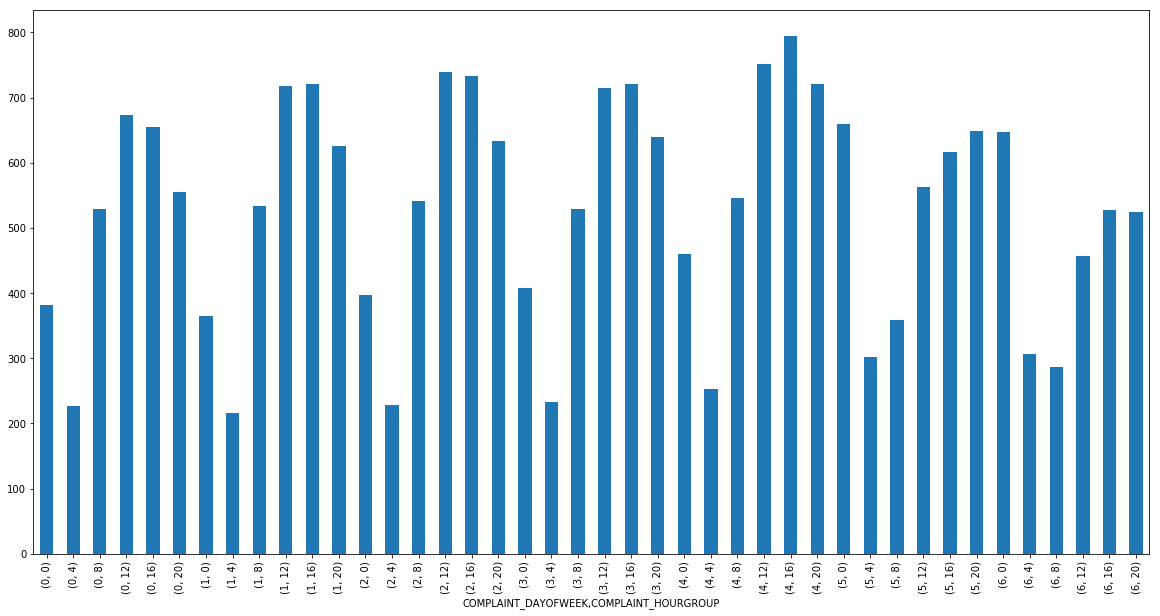

In [13]:
ax = pivoted_weekday_precinct.mean(axis=1).plot(kind='bar', figsize=(20,10))
ax.figure.savefig('mean_complaints_by_dayofweek_time.png')

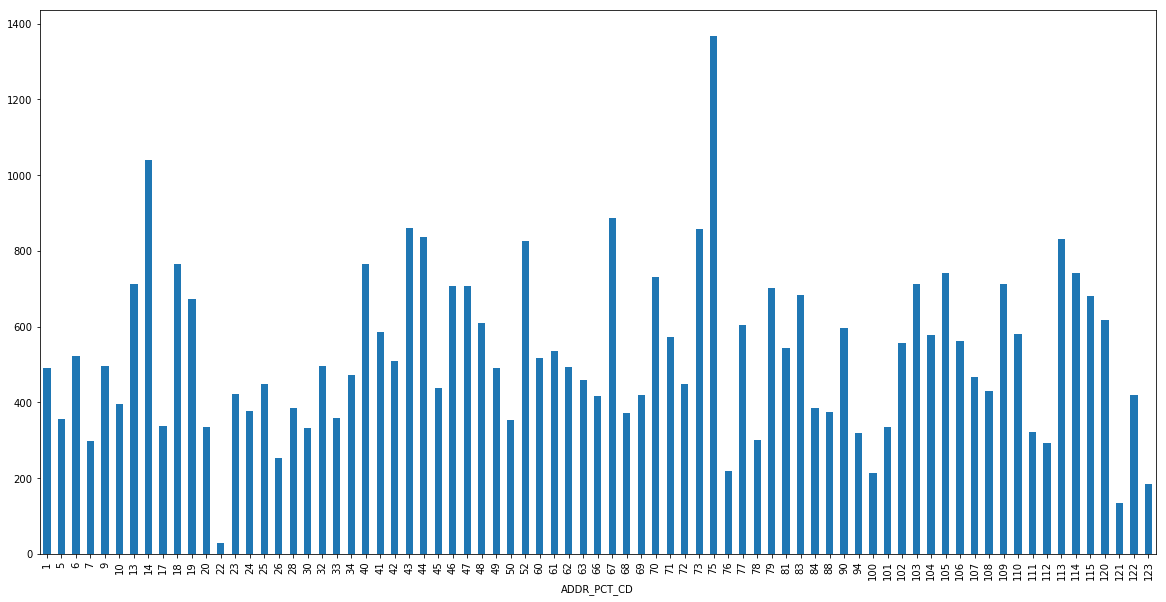

In [14]:
ax = pivoted_weekday_precinct.mean(axis=0).plot(kind='bar', figsize=(20,10))
ax.figure.savefig('mean_complaints_by_precinct.png')

In [15]:
summed_weekday_precinct = nypd_data.pivot_table(
    index=[
        'COMPLAINT_DAYOFWEEK',   
        'COMPLAINT_HOURGROUP',
        'ADDR_PCT_CD',
    ],
    values='KY_CD',
    fill_value=0,
    aggfunc=len
).reset_index()

summed_weekday_precinct['COMPLAINT_DAY_HOUR'] = \
    summed_weekday_precinct['COMPLAINT_DAYOFWEEK'].astype(str) + \
    '_' + \
    summed_weekday_precinct['COMPLAINT_HOURGROUP'].astype(str)

In [16]:
def eval_ridge(X_train, X_test, y_train, y_test):
    ridge = Ridge()
    ridge.fit(X_train, y_train)
    print('R2 (log space):', ridge.score(X_test, y_test))
    print('R2 (actual space):', r2_score(np.exp(y_test), np.exp(ridge.predict(X_test))))
    print('Baseline: ', np.exp(ridge.intercept_))
    for col, val in zip(X.columns, ridge.coef_):
        print('{0: <30}'.format(col), '{0:.0f}%'.format(100*(-1+np.exp(val))))
    return ridge

In [17]:
# Results using only weekday + time of day

X = pd.get_dummies(summed_weekday_precinct[['COMPLAINT_DAY_HOUR']].astype(str))
y = np.log(1 + summed_weekday_precinct['KY_CD'].values)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=4800)
eval_ridge(X_train, X_test, y_train, y_test)

R2 (log space): 0.310624330263
R2 (actual space): 0.27339849001
Baseline:  436.388970627
COMPLAINT_DAY_HOUR_0_0         -25%
COMPLAINT_DAY_HOUR_0_12        50%
COMPLAINT_DAY_HOUR_0_16        40%
COMPLAINT_DAY_HOUR_0_20        15%
COMPLAINT_DAY_HOUR_0_4         -56%
COMPLAINT_DAY_HOUR_0_8         5%
COMPLAINT_DAY_HOUR_1_0         -28%
COMPLAINT_DAY_HOUR_1_12        54%
COMPLAINT_DAY_HOUR_1_16        52%
COMPLAINT_DAY_HOUR_1_20        31%
COMPLAINT_DAY_HOUR_1_4         -57%
COMPLAINT_DAY_HOUR_1_8         17%
COMPLAINT_DAY_HOUR_2_0         -20%
COMPLAINT_DAY_HOUR_2_12        54%
COMPLAINT_DAY_HOUR_2_16        57%
COMPLAINT_DAY_HOUR_2_20        40%
COMPLAINT_DAY_HOUR_2_4         -55%
COMPLAINT_DAY_HOUR_2_8         7%
COMPLAINT_DAY_HOUR_3_0         -19%
COMPLAINT_DAY_HOUR_3_12        45%
COMPLAINT_DAY_HOUR_3_16        48%
COMPLAINT_DAY_HOUR_3_20        30%
COMPLAINT_DAY_HOUR_3_4         -56%
COMPLAINT_DAY_HOUR_3_8         8%
COMPLAINT_DAY_HOUR_4_0         -10%
COMPLAINT_DAY_HOUR_4_12       

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [18]:
# Results using only precinct code

X = pd.get_dummies(summed_weekday_precinct[['ADDR_PCT_CD']].astype(str))
y = np.log(1 + summed_weekday_precinct['KY_CD'].values)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=4800)
eval_ridge(X_train, X_test, y_train, y_test)

R2 (log space): 0.499296944186
R2 (actual space): 0.446334442653
Baseline:  439.427071833
ADDR_PCT_CD_1                  -8%
ADDR_PCT_CD_10                 -18%
ADDR_PCT_CD_100                -56%
ADDR_PCT_CD_101                -25%
ADDR_PCT_CD_102                19%
ADDR_PCT_CD_103                49%
ADDR_PCT_CD_104                33%
ADDR_PCT_CD_105                61%
ADDR_PCT_CD_106                22%
ADDR_PCT_CD_107                -6%
ADDR_PCT_CD_108                -4%
ADDR_PCT_CD_109                45%
ADDR_PCT_CD_110                22%
ADDR_PCT_CD_111                -34%
ADDR_PCT_CD_112                -42%
ADDR_PCT_CD_113                76%
ADDR_PCT_CD_114                51%
ADDR_PCT_CD_115                47%
ADDR_PCT_CD_120                30%
ADDR_PCT_CD_121                -70%
ADDR_PCT_CD_122                -9%
ADDR_PCT_CD_123                -58%
ADDR_PCT_CD_13                 40%
ADDR_PCT_CD_14                 100%
ADDR_PCT_CD_17                 -32%
ADDR_PCT_CD_18            

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [19]:
# Results using both precinct code and weekday + time of day

X = pd.get_dummies(summed_weekday_precinct[['COMPLAINT_DAY_HOUR', 'ADDR_PCT_CD']].astype(str))
y = np.log(1 + summed_weekday_precinct['KY_CD'].values)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=4800)
eval_ridge(X_train, X_test, y_train, y_test)

R2 (log space): 0.928748445954
R2 (actual space): 0.907820978797
Baseline:  438.486809745
COMPLAINT_DAY_HOUR_0_0         -23%
COMPLAINT_DAY_HOUR_0_12        39%
COMPLAINT_DAY_HOUR_0_16        34%
COMPLAINT_DAY_HOUR_0_20        13%
COMPLAINT_DAY_HOUR_0_4         -55%
COMPLAINT_DAY_HOUR_0_8         7%
COMPLAINT_DAY_HOUR_1_0         -27%
COMPLAINT_DAY_HOUR_1_12        46%
COMPLAINT_DAY_HOUR_1_16        48%
COMPLAINT_DAY_HOUR_1_20        26%
COMPLAINT_DAY_HOUR_1_4         -57%
COMPLAINT_DAY_HOUR_1_8         9%
COMPLAINT_DAY_HOUR_2_0         -20%
COMPLAINT_DAY_HOUR_2_12        51%
COMPLAINT_DAY_HOUR_2_16        48%
COMPLAINT_DAY_HOUR_2_20        30%
COMPLAINT_DAY_HOUR_2_4         -54%
COMPLAINT_DAY_HOUR_2_8         9%
COMPLAINT_DAY_HOUR_3_0         -19%
COMPLAINT_DAY_HOUR_3_12        44%
COMPLAINT_DAY_HOUR_3_16        48%
COMPLAINT_DAY_HOUR_3_20        29%
COMPLAINT_DAY_HOUR_3_4         -53%
COMPLAINT_DAY_HOUR_3_8         9%
COMPLAINT_DAY_HOUR_4_0         -8%
COMPLAINT_DAY_HOUR_4_12        

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [20]:
np.sum(np.exp(y) - 1)

1704817.0

In [21]:
len(nypd_data)

1704817

In [22]:
X

,COMPLAINT_DAY_HOUR_0_0,COMPLAINT_DAY_HOUR_0_12,COMPLAINT_DAY_HOUR_0_16,COMPLAINT_DAY_HOUR_0_20,COMPLAINT_DAY_HOUR_0_4,COMPLAINT_DAY_HOUR_0_8,COMPLAINT_DAY_HOUR_1_0,COMPLAINT_DAY_HOUR_1_12,COMPLAINT_DAY_HOUR_1_16,COMPLAINT_DAY_HOUR_1_20,...,ADDR_PCT_CD_77,ADDR_PCT_CD_78,ADDR_PCT_CD_79,ADDR_PCT_CD_81,ADDR_PCT_CD_83,ADDR_PCT_CD_84,ADDR_PCT_CD_88,ADDR_PCT_CD_9,ADDR_PCT_CD_90,ADDR_PCT_CD_94
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
len(y)

3234

In [24]:
len(X.columns)

119